# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import workspace_utils
from workspace_utils import active_session


%matplotlib inline


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
## YOUR CODE HERE ##
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
batchsize = 64

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Create training set and define training dataloader
traindata = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
trainset, valset = torch.utils.data.dataset.random_split(traindata, [int(0.9*len(traindata)), int(0.1*len(traindata))])

# Create test set and define test dataloader

train_loader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=500, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
images, lables = next(iter(train_loader))

print(images.shape)
print(lables.shape)

torch.Size([50, 3, 224, 224])
torch.Size([50])


In [7]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


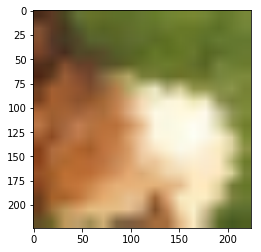

dog


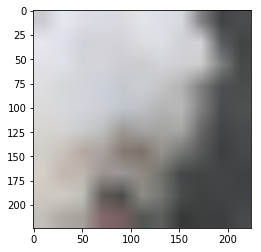

cat


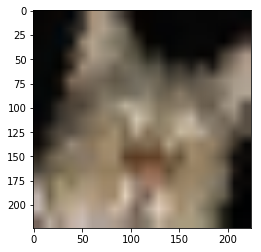

frog


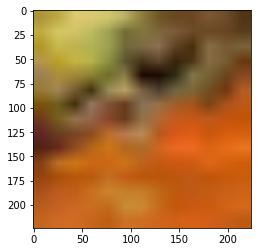

dog


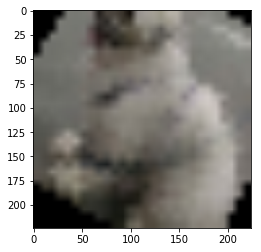

In [8]:
# Explore data
show5(train_loader)

## YOUR CODE HERE ##

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
## YOUR CODE HERE ##

model = torchvision.models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad=False
    
model

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 103446970.34it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [10]:
class classifier(nn.Module):      
    def __init__(self):
        super().__init__()
        
        #defining the layers of the fully connected Network
        
        self.fc1 = nn.Linear(2208, 1024)   
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,256) 
        self.output = nn.Linear(256, 10)    
        
        self.dropout = nn.Dropout(p = 0.2)  #defining dropout 
    
    def forward(self, x):
        
        x = x.view(x.shape[0], -1) #flattening the input
        
        #defining a forward pass
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.output(x), dim = 1)  #no dropout on the output layer

        return x


model.classifier = classifier()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
## YOUR CODE HERE ##

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [14]:
with active_session():

    epochs = 4
    print_every = 250

    steps=0
    running_loss, val_losses, accuracy_list, test_losses, train_losses =[], [], [], [], []

    for e in range(epochs):
        running_loss = 0

        model.train()

        for step, (inputs, lables) in enumerate(train_loader):

            inputs, lables = inputs.to(device), lables.to(device)

            logps = model.forward(inputs)

            loss = criterion(logps, lables)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            steps +=1

            if steps % 250 ==0:
                val_losses = 0
                accuracy = 0
                model.eval()

                with torch.no_grad():

                    for inputs,lables in valloader:

                        inputs, lables = inputs.to(device), lables.to(device)

                        logps = model.forward(inputs)

                        batch_loss = criterion(logps, lables)

                        val_losses += batch_loss.item()

                        ps = torch.exp(logps)

                        top_p, top_class = ps.topk(1, dim=1)

                        equals = top_class == lables.view(*top_class.shape)

                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                train_losses.append(running_loss/len(train_loader))
                test_losses.append(val_losses/len(valloader))
                accuracy_list.append(accuracy/len(valloader)) 


                print(f"Epoch {e+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {val_losses/len(valloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(valloader):.3f}")
                running_loss = 0
                model.train()  
                
            
                
        

Epoch 1/4.. Train loss: 1.817.. Test loss: 1.565.. Test accuracy: 0.390
Epoch 1/4.. Train loss: 1.552.. Test loss: 1.491.. Test accuracy: 0.468
Epoch 1/4.. Train loss: 1.457.. Test loss: 1.432.. Test accuracy: 0.487
Epoch 2/4.. Train loss: 0.565.. Test loss: 1.355.. Test accuracy: 0.527
Epoch 2/4.. Train loss: 1.388.. Test loss: 1.323.. Test accuracy: 0.532
Epoch 2/4.. Train loss: 1.386.. Test loss: 1.324.. Test accuracy: 0.535
Epoch 2/4.. Train loss: 1.370.. Test loss: 1.254.. Test accuracy: 0.552
Epoch 3/4.. Train loss: 1.082.. Test loss: 1.269.. Test accuracy: 0.555
Epoch 3/4.. Train loss: 1.337.. Test loss: 1.258.. Test accuracy: 0.538
Epoch 3/4.. Train loss: 1.334.. Test loss: 1.255.. Test accuracy: 0.555
Epoch 4/4.. Train loss: 0.272.. Test loss: 1.239.. Test accuracy: 0.550
Epoch 4/4.. Train loss: 1.320.. Test loss: 1.202.. Test accuracy: 0.575
Epoch 4/4.. Train loss: 1.324.. Test loss: 1.266.. Test accuracy: 0.545
Epoch 4/4.. Train loss: 1.320.. Test loss: 1.235.. Test accuracy

Plot the training loss (and validation loss/accuracy, if recorded).

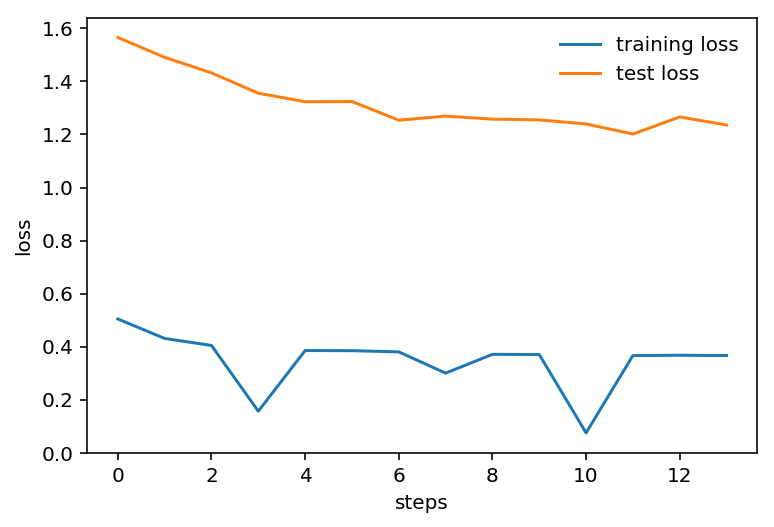

In [15]:
## YOUR CODE HERE ##
%config InlineBackend.figure_format = 'retina'

plt.plot(figsize = [8,5])
plt.plot(train_losses, label= 'training loss')
plt.plot(test_losses, label= 'test loss')
plt.xlabel('steps')

plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()

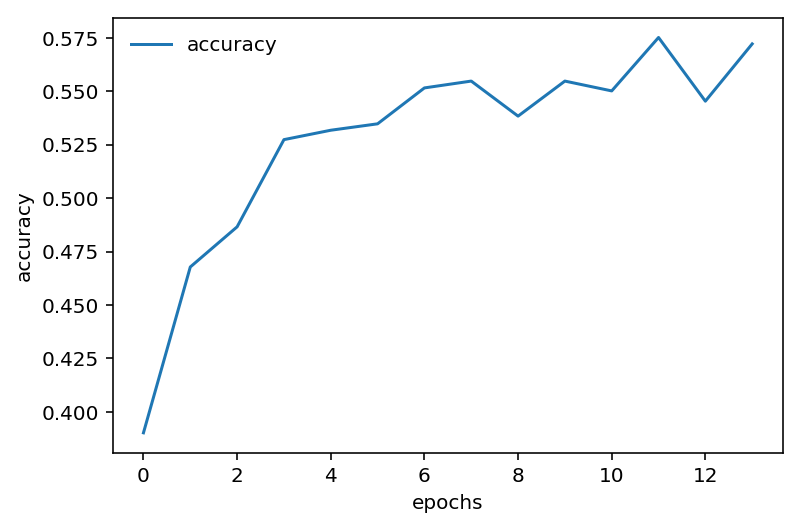

In [16]:
# Plotting the accuracy for each epoch
plt.plot(figsize = [8,5])
plt.plot(accuracy_list, label= 'accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
## YOUR CODE HERE ##
accuracy = 0
with torch.no_grad():
    model.eval()
    for inputs, lables in test_loader:
        
        inputs, lables = inputs.to(device), lables.to(device)
        
        log_ps = model(inputs)
        
        ps = torch.exp(log_ps)
        
        top_p, top_class = ps.topk(1, dim=1)
        
        equals = top_class == lables.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print('Test Accuracy: {:.2f}%'.format(accuracy/len(test_loader)*100))



Test Accuracy: 78.40%


## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'CIFAR10_image_classifier.pth')


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



Answer

Based on the result my model the accuracy on test set is around 78% which is higher than what Detectocorp's can do. So we can use the current algorithm since it achievs higher accuracy. To achive this score, I used pretrained models and dropout to hinder the model to ovefiton trainset. Far more advanced solution reached accuracy around 90 to 95% which is really higher than the accuracy I obtained. More epochs and caring more for the optimization of the parameters could improve the current model. 


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).